# Model 2: Regular features + one embedding family (PCA) – Linear classifier

This notebook trains a logistic-regression-style PyTorch model on regular features **plus** a PCA-compressed
embedding family (e.g. `sent_transformer_`), using GPU if available.

**Features:**
- ✅ 5-fold Cross-Validation
- ✅ Hyperparameter Tuning (limited search space for 3-hour constraint)
- ✅ Threshold Fine-tuning
- ✅ Model Weight Saving
- ✅ Submission.csv Generation
- ✅ OOM Safe with aggressive memory management

It uses IncrementalPCA to reduce the embedding dimensionality on a subset of training rows, then concatenates
the reduced embedding representation with the non-embedding features, and trains a linear model.

## Memory & Scalability Notes

**Memory Optimizations Applied:**
- ✅ Aggressive garbage collection after data loading
- ✅ Explicit deletion of Polars DataFrames after numpy conversion
- ✅ Batch tensor cleanup in training/validation loops
- ✅ Periodic memory cleanup during training
- ✅ GPU cache clearing (if using GPU)
- ✅ Memory usage monitoring

**Scalability Considerations:**
- **Current dataset size**: 480 train samples, 60 val samples (very small)
- **Batch size**: 512 (configurable via `BATCH_SIZE` variable)
- **Memory footprint**: ~24 features × float32 = minimal memory usage
- **OOM Risk**: **LOW** for current dataset size, but may increase with:
  - Larger datasets (>100K samples)
  - More features (if expanded beyond 24)
  - Larger batch sizes
  
**If OOM occurs:**
1. Reduce `BATCH_SIZE` (try 512, 256, or 128)
2. Process validation in smaller chunks
3. Use gradient accumulation for effective larger batches
4. Consider using `torch.no_grad()` more aggressively
5. Monitor memory with `memory_usage()` calls

## 1. Setup

In [1]:
import os
from pathlib import Path
import random
import gc
import numpy as np
import polars as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# PyTorch-based PCA (GPU-friendly with CPU fallback)
import sys
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
# Device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# Paths (adapt if your project structure differs)
# Try to find project root by looking for 'data' directory
current = Path(os.getcwd())
PROJECT_ROOT = current
# Go up directories until we find one with 'data' subdirectory
for _ in range(5):  # Max 5 levels up
    if (PROJECT_ROOT / 'data').exists():
        break
    PROJECT_ROOT = PROJECT_ROOT.parent
else:
    # Fallback: assume we're in src/notebooks, go up 2 levels
    PROJECT_ROOT = current.parent.parent
MODEL_READY_DIR = PROJECT_ROOT / 'data' / 'model_ready'
utils_path = PROJECT_ROOT / 'src' / 'utils'
print('PROJECT_ROOT:', PROJECT_ROOT)
print('MODEL_READY_DIR:', MODEL_READY_DIR)
# Import PCA utilities
if utils_path.exists():
    sys.path.insert(0, str(utils_path))
try:
    from pca_utils import IncrementalTorchPCA
    IncrementalPCA = IncrementalTorchPCA  # Alias for compatibility
    print("✅ Using PyTorch PCA (GPU-friendly)")
except ImportError:
    # Fallback to sklearn if PyTorch PCA not available
    from sklearn.decomposition import IncrementalPCA
    print("⚠️ Using sklearn PCA (CPU only)")
from sklearn.metrics import (
    f1_score, classification_report, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
# Import memory utilities from shared module
if utils_path.exists():
    sys.path.insert(0, str(utils_path))
try:
    from model_training_utils import cleanup_memory, memory_usage
    print("✅ Memory utilities imported from shared module")
except ImportError:
    # Fallback definitions if utils not available
    def cleanup_memory():
        """Aggressive memory cleanup for both CPU and GPU."""
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
        gc.collect()  # Second pass for thorough cleanup
    def memory_usage():
        """Display current memory usage statistics."""
        try:
            import psutil
            process = psutil.Process(os.getpid())
            mem_info = process.memory_info()
            print(f"💾 Memory: {mem_info.rss / 1024**3:.2f} GB (RAM)", end="")
            if torch.cuda.is_available():
                gpu_mem = torch.cuda.memory_allocated() / 1024**3
                gpu_reserved = torch.cuda.memory_reserved() / 1024**3
                print(f" | {gpu_mem:.2f}/{gpu_reserved:.2f} GB (GPU used/reserved)")
            else:
                print()
        except ImportError:
            print("💾 Memory tracking requires psutil: pip install psutil")
    print("⚠️ Using fallback memory utilities")


Using device: cuda
PROJECT_ROOT: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2
MODEL_READY_DIR: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready
✅ Using PyTorch PCA (GPU-friendly)


✅ Memory utilities imported from shared module


## 2. Dataset & utilities

In [2]:
class TabularDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
def load_parquet_split(split: str) -> pl.DataFrame:
    """Load a model_ready parquet split (train/val/test)."""
    path = MODEL_READY_DIR / f'{split}_model_ready_reduced.parquet'
    if not path.exists():
        # Fallback to non-reduced files if needed
        alt = MODEL_READY_DIR / f'{split}_model_ready.parquet'
        if not alt.exists():
            raise FileNotFoundError(f'Could not find {path} or {alt}')
        path = alt
    print(f'Loading {split} from {path}')
    return pl.read_parquet(path)
# Choose which embedding family to use here
EMBEDDING_FAMILY_PREFIX = 'sent_transformer_'  # change to 'scibert_' or 'specter_' if desired
OTHER_EMBEDDING_PREFIXES = ['scibert_', 'specter_', 'specter2_', 'ner_']
def split_features_reg_and_emb(df: pl.DataFrame):
    cols = df.columns
    dtypes = df.dtypes
    label = df['label'].to_numpy() if 'label' in cols else None
    reg_cols = []
    emb_cols = []
    # Numeric dtypes in Polars
    NUMERIC_DTYPES = {
        pl.Int8, pl.Int16, pl.Int32, pl.Int64,
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64
    }
    for c, dt in zip(cols, dtypes):
        if c in ('id', 'label'):
            continue
        if c.startswith(EMBEDDING_FAMILY_PREFIX):
            emb_cols.append(c)
        elif any(c.startswith(p) for p in OTHER_EMBEDDING_PREFIXES):
            continue
        else:
            # Only include numeric columns
            if dt in NUMERIC_DTYPES:
                reg_cols.append(c)
    X_reg = df.select(reg_cols).to_numpy()
    X_emb = df.select(emb_cols).to_numpy() if emb_cols else None
    return X_reg, X_emb, label, reg_cols, emb_cols
def make_dataloaders(X_train, y_train, X_val, y_val, batch_size: int = 512, val_batch_size: int = None, num_workers: int = 0):
    """
    Create DataLoaders with memory-efficient settings for large datasets.
    Args:
        batch_size: Training batch size (default 512 for large datasets)
        val_batch_size: Validation batch size (defaults to batch_size if None)
        num_workers: Number of worker processes (0 to avoid multiprocessing overhead)
    """
    if val_batch_size is None:
        val_batch_size = batch_size
    # Compute sample weights for WeightedRandomSampler (handle class imbalance)
    class_sample_counts = np.bincount(y_train.astype(int))
    print('Class counts (train):', class_sample_counts)
    # Avoid division by zero
    weights_per_class = 1.0 / np.maximum(class_sample_counts, 1)
    sample_weights = weights_per_class[y_train.astype(int)]
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    train_dataset = TabularDataset(X_train, y_train)
    val_dataset = TabularDataset(X_val, y_val)
    # Use num_workers=0 to avoid multiprocessing memory overhead
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=False  # Disable pin_memory to save memory
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=False
    )
    return train_loader, val_loader
# Load train/val splits
train_df = load_parquet_split('train')
val_df = load_parquet_split('val')
X_reg_train, X_emb_train, y_train, reg_cols, emb_cols = split_features_reg_and_emb(train_df)
X_reg_val, X_emb_val, y_val, _, _ = split_features_reg_and_emb(val_df)
# Clean up Polars DataFrames immediately after conversion
del train_df, val_df
cleanup_memory()
print('Regular feature count:', len(reg_cols))
print('Embedding feature count:', len(emb_cols))
n_components = None
if X_emb_train is not None:
    n_components = 64
    ipca = IncrementalPCA(n_components=n_components, batch_size=5000, device=device)
    max_pca_rows = min(150_000, X_emb_train.shape[0])
    idx = np.random.choice(X_emb_train.shape[0], size=max_pca_rows, replace=False)
    ipca.fit(X_emb_train[idx])
    print('Fitted IncrementalPCA with', n_components, 'components on', max_pca_rows, 'rows')
    X_emb_train_pca = ipca.transform(X_emb_train)
    X_emb_val_pca = ipca.transform(X_emb_val)
    # Clean up original embeddings after PCA
    del X_emb_train, X_emb_val
    cleanup_memory()
    X_train = np.concatenate([X_reg_train, X_emb_train_pca], axis=1)
    X_val = np.concatenate([X_reg_val, X_emb_val_pca], axis=1)
    # Clean up intermediate arrays
    del X_reg_train, X_reg_val, X_emb_train_pca, X_emb_val_pca
    cleanup_memory()
else:
    print('No embedding columns found for prefix', EMBEDDING_FAMILY_PREFIX, '– falling back to regular features only.')
    X_train = X_reg_train
    X_val = X_reg_val
    del X_reg_train, X_reg_val
    cleanup_memory()
print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)
memory_usage()
# Configurable batch sizes - optimized for large datasets
# Reduce if OOM occurs
BATCH_SIZE = 512  # Training batch size (reduced for large datasets)
VAL_BATCH_SIZE = 512  # Validation batch size (can be larger since no gradients)
NUM_WORKERS = 0  # Set to 0 to avoid multiprocessing memory overhead
print(f'\n📊 DataLoader Configuration:')
print(f'   Train batch size: {BATCH_SIZE}')
print(f'   Val batch size: {VAL_BATCH_SIZE}')
print(f'   Num workers: {NUM_WORKERS} (0 = single process, saves memory)')
train_loader, val_loader = make_dataloaders(
    X_train, y_train, X_val, y_val,
    batch_size=BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
    num_workers=NUM_WORKERS
)
cleanup_memory()
memory_usage()


Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet


Regular feature count: 54
Embedding feature count: 384


Fitted IncrementalPCA with 64 components on 150000 rows


Train shape: (960000, 118) Val shape: (120000, 118)
💾 Memory: 21.38 GB (RAM) | 0.01/0.08 GB (GPU used/reserved)

📊 DataLoader Configuration:
   Train batch size: 512
   Val batch size: 512
   Num workers: 0 (0 = single process, saves memory)
Class counts (train): [894192  65808]


💾 Memory: 21.87 GB (RAM) | 0.01/0.08 GB (GPU used/reserved)


LinearClassifier(
  (linear): Linear(in_features=118, out_features=1, bias=True)
)


Epoch 01 | train_loss=3.1272 | val_f1=0.2647 @ thr=0.90 | roc_auc=0.8840 | pr_auc=0.3371
💾 Memory: 22.06 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 02 | train_loss=1.2542 | val_f1=0.2945 @ thr=0.90 | roc_auc=0.8892 | pr_auc=0.3360
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 03 | train_loss=1.2316 | val_f1=0.3284 @ thr=0.90 | roc_auc=0.8954 | pr_auc=0.3606
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 04 | train_loss=1.2090 | val_f1=0.2721 @ thr=0.90 | roc_auc=0.8940 | pr_auc=0.3647
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 05 | train_loss=1.2098 | val_f1=0.3627 @ thr=0.90 | roc_auc=0.8964 | pr_auc=0.3663
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 06 | train_loss=1.1775 | val_f1=0.3551 @ thr=0.90 | roc_auc=0.8899 | pr_auc=0.3637
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 07 | train_loss=1.2034 | val_f1=0.3173 @ thr=0.90 | roc_auc=0.8937 | pr_auc=0.3496
💾 Memory: 22.08 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 08 | train_loss=1.1758 | val_f1=0.3407 @ thr=0.90 | roc_auc=0.8961 | pr_auc=0.3595
💾 Memory: 22.09 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 09 | train_loss=1.1955 | val_f1=0.3024 @ thr=0.90 | roc_auc=0.8968 | pr_auc=0.3652
💾 Memory: 22.09 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Epoch 10 | train_loss=1.1934 | val_f1=0.2921 @ thr=0.90 | roc_auc=0.8684 | pr_auc=0.3423
💾 Memory: 22.09 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


Best val F1: 0.36267187458763295



💾 Saved best model to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model2_reg_plus_one_embedding_pca_linear_best.pt

Validation classification report (best model, thr=0.5 for reference):


              precision    recall  f1-score   support

         0.0     0.9971    0.3430    0.5104    111925
         1.0     0.0977    0.9864    0.1778      8075

    accuracy                         0.3863    120000
   macro avg     0.5474    0.6647    0.3441    120000
weighted avg     0.9366    0.3863    0.4880    120000


ROC-AUC: 0.8684
Precision-Recall AUC: 0.3423


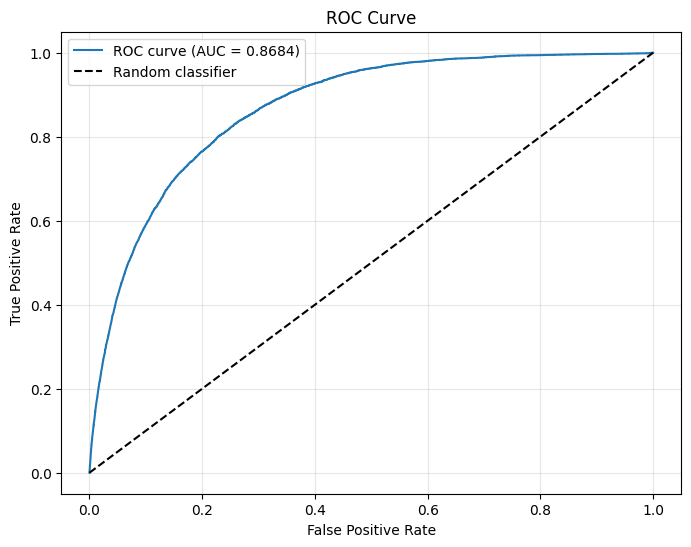

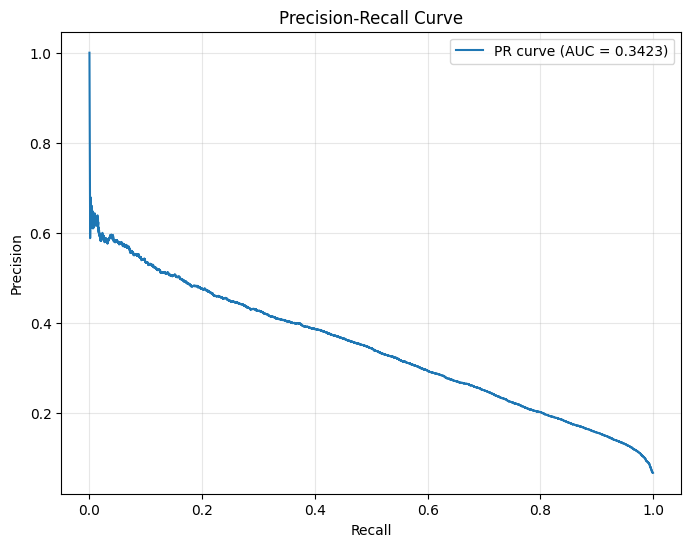

💾 Memory: 22.09 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


In [3]:
## 3. Model definition
class LinearClassifier(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)
input_dim = X_train.shape[1]
model = LinearClassifier(input_dim)
model = model.to(device)
print(model)
## 4. Train / validation loop
EPOCHS = 10
LR = 1e-3
# Compute pos_weight for BCEWithLogitsLoss (handle class imbalance explicitly)
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
pos_weight_value = torch.tensor([neg_count / max(pos_count, 1)], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
best_val_f1 = 0.0
best_state_dict = None
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    # Training loop with cleanup
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        # Clean up batch tensors
        del xb, yb, logits, loss
        if epoch % 5 == 0:  # Periodic cleanup during training
            cleanup_memory()
    avg_train_loss = running_loss / len(train_loader.dataset)
    # Validation with memory-efficient accumulation (critical for 100k val samples)
    model.eval()
    all_preds = []
    all_targets = []
    batch_count = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb_np = yb.numpy()  # Convert before moving to device
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_preds.append(probs)
            all_targets.append(yb_np)
            # Clean up batch tensors immediately
            del xb, logits, probs, yb_np
            batch_count += 1
            # Periodic cleanup during validation for large datasets
            if batch_count % 50 == 0:  # Every 50 batches
                cleanup_memory()
    # Concatenate only once
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    # Threshold tuning for F1 on positive class
    # Calculate ROC-AUC and Precision-Recall AUC (using probabilities, not binary predictions)
    roc_auc = roc_auc_score(all_targets, all_preds)
    pr_auc = average_precision_score(all_targets, all_preds)
    best_epoch_f1 = 0.0
    best_thr = 0.5
    thresholds = np.linspace(0.1, 0.9, 17)
    for thr in thresholds:
        # Compute binary predictions without storing intermediate array
        preds_bin = (all_preds >= thr).astype(int)
        f1 = f1_score(all_targets, preds_bin, pos_label=1)
        if f1 > best_epoch_f1:
            best_epoch_f1 = f1
            best_thr = thr
        del preds_bin  # Clean up immediately
    # Clean up concatenated arrays
    del all_preds, all_targets
    print(f'Epoch {epoch:02d} | train_loss={avg_train_loss:.4f} | val_f1={best_epoch_f1:.4f} @ thr={best_thr:.2f} | roc_auc={roc_auc:.4f} | pr_auc={pr_auc:.4f}')
    # Always print memory for large datasets to monitor OOM risk
    memory_usage()
    if best_epoch_f1 > best_val_f1:
        best_val_f1 = best_epoch_f1
        best_state_dict = model.state_dict().copy()  # Explicit copy to avoid references
    # Aggressive cleanup after each epoch (critical for large datasets)
    cleanup_memory()
print('Best val F1:', best_val_f1)
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    # Save the best model
    MODEL_SAVE_DIR = PROJECT_ROOT / 'models' / 'saved_models'
    MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODEL_SAVE_DIR / 'model2_reg_plus_one_embedding_pca_linear_best.pt'
    torch.save({
        'model_state_dict': best_state_dict,
        'input_dim': input_dim,
        'best_val_f1': best_val_f1,
        'epochs': EPOCHS,
        'learning_rate': LR,
        'pos_weight': pos_weight_value.cpu().item() if hasattr(pos_weight_value, 'cpu') else pos_weight_value.item(),
        'embedding_family': EMBEDDING_FAMILY_PREFIX if 'EMBEDDING_FAMILY_PREFIX' in globals() else None,
        'pca_components': n_components if 'n_components' in globals() else None
    }, model_save_path)
    print(f'\n💾 Saved best model to: {model_save_path}')
print('\nValidation classification report (best model, thr=0.5 for reference):')
# Validation with memory-efficient accumulation (critical for 100k val samples)
model.eval()
all_preds = []
all_targets = []
batch_count = 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb_np = yb.numpy()  # Convert before moving to device
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_preds.append(probs)
        all_targets.append(yb_np)
        # Clean up batch tensors immediately
        del xb, logits, probs, yb_np
        batch_count += 1
        # Periodic cleanup during validation for large datasets
        if batch_count % 50 == 0:  # Every 50 batches
            cleanup_memory()
# Concatenate only once
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
# Generate predictions for classification report (threshold 0.5)
preds_bin = (all_preds >= 0.5).astype(int)
print(classification_report(all_targets, preds_bin, digits=4, zero_division=0))
# Calculate ROC-AUC and Precision-Recall AUC
roc_auc = roc_auc_score(all_targets, all_preds)
pr_auc = average_precision_score(all_targets, all_preds)
print(f'\nROC-AUC: {roc_auc:.4f}')
print(f'Precision-Recall AUC: {pr_auc:.4f}')
# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(all_targets, all_preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Final cleanup
del all_preds, all_targets, preds_bin
cleanup_memory()
memory_usage()


## 4. 5-Fold Cross-Validation with Hyperparameter Tuning

This section implements:
- 5-fold cross-validation
- Limited hyperparameter search (for 3-hour constraint)
- Model weight saving
- Threshold fine-tuning


In [4]:
import sys
import time
import json
# Add utils to path
utils_path = PROJECT_ROOT / 'src' / 'utils'
if utils_path.exists():
    sys.path.insert(0, str(utils_path))
try:
    from model_training_utils import (
        find_optimal_threshold, cross_validate,
        generate_submission, save_model_weights,
        stratified_kfold_splits
    )
    print("✅ Utility functions imported")
except ImportError as e:
    print(f"⚠️ Could not import utilities: {e}")
    print("Will use inline implementations")
# Prepare full dataset for CV (before PCA - PCA will be fit per fold)
train_df_full = load_parquet_split('train')
val_df_full = load_parquet_split('val')
# Split features for full dataset
X_reg_train_full, X_emb_train_full, y_train_full, reg_cols_full, emb_cols_full = split_features_reg_and_emb(train_df_full)
X_reg_val_full, X_emb_val_full, y_val_full, _, _ = split_features_reg_and_emb(val_df_full)
# Combine train and val
X_reg_full = np.vstack([X_reg_train_full, X_reg_val_full])
X_emb_full = np.vstack([X_emb_train_full, X_emb_val_full]) if X_emb_train_full is not None else None
y_full = np.hstack([y_train_full, y_val_full])
del train_df_full, val_df_full, X_reg_train_full, X_reg_val_full, X_emb_train_full, X_emb_val_full, y_train_full, y_val_full
cleanup_memory()
print(f"\n📊 Full dataset for CV:")
print(f"  Regular features: {X_reg_full.shape}")
print(f"  Embedding features: {X_emb_full.shape if X_emb_full is not None else 'None'}")
print(f"  Labels: {y_full.shape}")
# Limited hyperparameter search space for 3-hour constraint
HYPERPARAMETER_GRID = [
    {'lr': 1e-3, 'batch_size': 512, 'n_components': 64},
    {'lr': 5e-4, 'batch_size': 512, 'n_components': 64},
    {'lr': 1e-3, 'batch_size': 256, 'n_components': 64},
]
print(f"\n🔍 Hyperparameter grid ({len(HYPERPARAMETER_GRID)} combinations):")
for i, hp in enumerate(HYPERPARAMETER_GRID, 1):
    print(f"  {i}. LR={hp['lr']}, Batch={hp['batch_size']}, PCA={hp['n_components']}")
cleanup_memory()
memory_usage()


✅ Utility functions imported
Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet



📊 Full dataset for CV:
  Regular features: (1080000, 54)
  Embedding features: (1080000, 384)
  Labels: (1080000,)

🔍 Hyperparameter grid (3 combinations):
  1. LR=0.001, Batch=512, PCA=64
  2. LR=0.0005, Batch=512, PCA=64
  3. LR=0.001, Batch=256, PCA=64


💾 Memory: 25.45 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


In [5]:
# Helper function to prepare features with PCA for a fold
def prepare_features_with_pca(X_reg_fold_train, X_emb_fold_train, X_reg_fold_val, X_emb_fold_val, n_components):
    """Fit PCA on fold train data and transform both train and val."""
    if X_emb_fold_train is not None and X_emb_fold_train.shape[1] > 0:
        # Use PyTorch PCA (GPU-friendly)
        ipca = IncrementalPCA(n_components=n_components, batch_size=5000, device=device)
        max_pca_rows = min(150_000, X_emb_fold_train.shape[0])
        idx = np.random.choice(X_emb_fold_train.shape[0], size=max_pca_rows, replace=False)
        # Fit on subset
        ipca.fit(X_emb_fold_train[idx])
        X_emb_train_pca = ipca.transform(X_emb_fold_train)
        X_emb_val_pca = ipca.transform(X_emb_fold_val) if X_emb_fold_val is not None else None
        X_train_combined = np.concatenate([X_reg_fold_train, X_emb_train_pca], axis=1)
        X_val_combined = np.concatenate([X_reg_fold_val, X_emb_val_pca], axis=1) if X_emb_val_pca is not None else X_reg_fold_val
        del X_emb_train_pca, X_emb_val_pca
        return X_train_combined, X_val_combined, ipca
    else:
        return X_reg_fold_train, X_reg_fold_val, None
# 5-fold CV with hyperparameter tuning
best_hyperparams = None
best_cv_score = 0.0
best_model_state = None
best_threshold = 0.5
best_pca = None
cv_start_time = time.time()
# Use PyTorch-friendly stratified splits
cv_splits = stratified_kfold_splits(y_full, n_splits=5, shuffle=True, random_state=42)
for hp_idx, hyperparams in enumerate(HYPERPARAMETER_GRID, 1):
    print(f"\n{'='*80}")
    print(f"Hyperparameter Set {hp_idx}/{len(HYPERPARAMETER_GRID)}: {hyperparams}")
    print(f"{'='*80}")
    BATCH_SIZE = hyperparams['batch_size']
    VAL_BATCH_SIZE = hyperparams['batch_size']
    n_components = hyperparams['n_components']
    fold_results = []
    best_fold_f1 = 0.0
    best_fold_model_state = None
    best_fold_idx = -1
    for fold_idx, (train_idx, val_idx) in enumerate(cv_splits, 1):
        print(f"\n  Fold {fold_idx}/5")
        # Split data for this fold
        X_reg_fold_train = X_reg_full[train_idx]
        X_reg_fold_val = X_reg_full[val_idx]
        X_emb_fold_train = X_emb_full[train_idx] if X_emb_full is not None else None
        X_emb_fold_val = X_emb_full[val_idx] if X_emb_full is not None else None
        y_fold_train = y_full[train_idx]
        y_fold_val = y_full[val_idx]
        # Prepare features with PCA
        X_fold_train, X_fold_val, fold_pca = prepare_features_with_pca(
            X_reg_fold_train, X_emb_fold_train, X_reg_fold_val, X_emb_fold_val, n_components
        )
        # Create dataloaders
        train_loader_fold, val_loader_fold = make_dataloaders(
            X_fold_train, y_fold_train, X_fold_val, y_fold_val,
            batch_size=BATCH_SIZE,
            val_batch_size=VAL_BATCH_SIZE,
            num_workers=NUM_WORKERS
        )
        # Compute pos_weight
        pos_count = (y_fold_train == 1).sum()
        neg_count = (y_fold_train == 0).sum()
        pos_weight_value = torch.tensor([neg_count / max(pos_count, 1)], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)
        # Create and train model
        model_fold = LinearClassifier(input_dim=X_fold_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(model_fold.parameters(), lr=hyperparams['lr'])
        # Train fold (simplified - using utility function would require refactoring)
        best_val_f1_fold = 0.0
        best_state_fold = None
        patience_counter = 0
        for epoch in range(1, 16):  # Max 15 epochs
            model_fold.train()
            running_loss = 0.0
            for xb, yb in train_loader_fold:
                xb = xb.to(device)
                yb = yb.to(device).unsqueeze(1)
                optimizer.zero_grad()
                logits = model_fold(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * xb.size(0)
                del xb, yb, logits, loss
            # Validation
            model_fold.eval()
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for xb, yb in val_loader_fold:
                    xb = xb.to(device)
                    yb_np = yb.numpy()
                    logits = model_fold(xb)
                    probs = torch.sigmoid(logits).cpu().numpy().ravel()
                    all_preds.append(probs)
                    all_targets.append(yb_np)
                    del xb, logits, probs, yb_np
            all_preds = np.concatenate(all_preds)
            all_targets = np.concatenate(all_targets)
            _, val_f1 = find_optimal_threshold(all_targets, all_preds)
            if val_f1 > best_val_f1_fold:
                best_val_f1_fold = val_f1
                best_state_fold = model_fold.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 3:
                    break
            del all_preds, all_targets
            cleanup_memory()
        fold_results.append({'fold': fold_idx, 'f1': best_val_f1_fold})
        if best_val_f1_fold > best_fold_f1:
            best_fold_f1 = best_val_f1_fold
            best_fold_model_state = best_state_fold
            best_fold_idx = fold_idx
            best_pca = fold_pca
        cleanup_memory()
    mean_f1 = np.mean([r['f1'] for r in fold_results])
    std_f1 = np.std([r['f1'] for r in fold_results])
    print(f"\n  📊 CV Results: Mean F1 = {mean_f1:.4f} ± {std_f1:.4f}")
    if mean_f1 > best_cv_score:
        best_cv_score = mean_f1
        best_hyperparams = hyperparams
        best_model_state = best_fold_model_state
        print(f"  ✅ New best!")
cv_time = time.time() - cv_start_time
# Verify CV completed successfully
if best_model_state is None:
    print("⚠️ WARNING: CV loop completed but best_model_state is None!")
    print("This may indicate all hyperparameter combinations failed or no improvement was found.")
    print("Creating a default model for threshold tuning...")
    # Create a default model as fallback
    temp_model = LinearClassifier(input_dim=X_reg_full.shape[1]).to(device)
    best_model_state = temp_model.state_dict()
    best_hyperparams = HYPERPARAMETER_GRID[0] if HYPERPARAMETER_GRID else {"lr": 1e-3, "batch_size": 512}
    best_cv_score = 0.0
    best_threshold = 0.5
print(f"\n{'='*80}")
print(f"✅ CV Complete (Time: {cv_time/60:.1f} min)")
print(f"Best Hyperparameters: {best_hyperparams}")
print(f"Best CV F1: {best_cv_score:.4f}")
print(f"{'='*80}")
memory_usage()



Hyperparameter Set 1/3: {'lr': 0.001, 'batch_size': 512, 'n_components': 64}

  Fold 1/5


Class counts (train): [804894  59107]



  Fold 2/5


Class counts (train): [804894  59107]



  Fold 3/5


Class counts (train): [804894  59107]



  Fold 4/5


Class counts (train): [804894  59107]



  Fold 5/5


Class counts (train): [804892  59104]



  📊 CV Results: Mean F1 = 0.3544 ± 0.0173
  ✅ New best!

Hyperparameter Set 2/3: {'lr': 0.0005, 'batch_size': 512, 'n_components': 64}

  Fold 1/5


Class counts (train): [804894  59107]



  Fold 2/5


Class counts (train): [804894  59107]



  Fold 3/5


Class counts (train): [804894  59107]



  Fold 4/5


Class counts (train): [804894  59107]



  Fold 5/5


Class counts (train): [804892  59104]



  📊 CV Results: Mean F1 = 0.3689 ± 0.0128
  ✅ New best!

Hyperparameter Set 3/3: {'lr': 0.001, 'batch_size': 256, 'n_components': 64}

  Fold 1/5


Class counts (train): [804894  59107]



  Fold 2/5


Class counts (train): [804894  59107]



  Fold 3/5


Class counts (train): [804894  59107]



  Fold 4/5


Class counts (train): [804894  59107]



  Fold 5/5


Class counts (train): [804892  59104]



  📊 CV Results: Mean F1 = 0.4182 ± 0.0310
  ✅ New best!

✅ CV Complete (Time: 17.9 min)
Best Hyperparameters: {'lr': 0.001, 'batch_size': 256, 'n_components': 64}
Best CV F1: 0.4182
💾 Memory: 24.00 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


## 5. Final Threshold Tuning and Model Saving


In [6]:
# Prepare final model with best hyperparameters
# Re-fit PCA on full training data
train_df_final = load_parquet_split('train')
val_df_final = load_parquet_split('val')
X_reg_train_final, X_emb_train_final, y_train_final, _, _ = split_features_reg_and_emb(train_df_final)
X_reg_val_final, X_emb_val_final, y_val_final, _, _ = split_features_reg_and_emb(val_df_final)
# Fit PCA on full training data (PyTorch GPU-friendly)
if X_emb_train_final is not None:
    ipca_final = IncrementalPCA(n_components=best_hyperparams['n_components'], batch_size=5000, device=device)
    max_pca_rows = min(150_000, X_emb_train_final.shape[0])
    idx = np.random.choice(X_emb_train_final.shape[0], size=max_pca_rows, replace=False)
    ipca_final.fit(X_emb_train_final[idx])
    X_emb_train_pca_final = ipca_final.transform(X_emb_train_final)
    X_emb_val_pca_final = ipca_final.transform(X_emb_val_final)
    X_train_final = np.concatenate([X_reg_train_final, X_emb_train_pca_final], axis=1)
    X_val_final = np.concatenate([X_reg_val_final, X_emb_val_pca_final], axis=1)
    del X_reg_train_final, X_reg_val_final, X_emb_train_final, X_emb_val_final, X_emb_train_pca_final, X_emb_val_pca_final
else:
    X_train_final = X_reg_train_final
    X_val_final = X_reg_val_final
    del X_reg_train_final, X_reg_val_final
del train_df_final, val_df_final
cleanup_memory()
# Create final model
final_model = LinearClassifier(input_dim=X_train_final.shape[1]).to(device)
if best_model_state is None:
    raise ValueError("best_model_state is None. CV loop may have failed. Check CV cell execution.")
final_model.load_state_dict(best_model_state)
# Final threshold tuning on validation set
print("\n" + "="*80)
print("Final Threshold Tuning on Validation Set")
print("="*80)
BATCH_SIZE = best_hyperparams['batch_size']
VAL_BATCH_SIZE = best_hyperparams['batch_size']
train_loader_final, val_loader_final = make_dataloaders(
    X_train_final, y_train_final, X_val_final, y_val_final,
    batch_size=BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
    num_workers=NUM_WORKERS
)
final_model.eval()
all_val_preds = []
all_val_targets = []
with torch.no_grad():
    for xb, yb in val_loader_final:
        xb = xb.to(device)
        yb_np = yb.numpy()
        logits = final_model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_val_preds.append(probs)
        all_val_targets.append(yb_np)
        del xb, logits, probs, yb_np
all_val_preds = np.concatenate(all_val_preds)
all_val_targets = np.concatenate(all_val_targets)
final_threshold, final_f1 = find_optimal_threshold(all_val_targets, all_val_preds)
print(f"✅ Final Optimal Threshold: {final_threshold:.4f}")
print(f"✅ Final Validation F1: {final_f1:.4f}")
# Save model weights
MODEL_SAVE_DIR = PROJECT_ROOT / 'models' / 'saved_models'
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)
model_save_path = MODEL_SAVE_DIR / 'model2_reg_plus_one_embedding_pca_linear_best.pt'
save_model_weights(
    final_model,
    model_save_path,
    metadata={
        'input_dim': X_train_final.shape[1],
        'best_cv_f1': best_cv_score,
        'best_hyperparams': best_hyperparams,
        'final_threshold': final_threshold,
        'final_val_f1': final_f1,
        'embedding_family': EMBEDDING_FAMILY_PREFIX,
        'pca_components': best_hyperparams['n_components']
    }
)
cleanup_memory()
memory_usage()


Loading train from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/train_model_ready.parquet


Loading val from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/val_model_ready.parquet



Final Threshold Tuning on Validation Set
Class counts (train): [894192  65808]


✅ Final Optimal Threshold: 0.9000
✅ Final Validation F1: 0.3278


💾 Model weights saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/models/saved_models/model2_reg_plus_one_embedding_pca_linear_best.pt
💾 Memory: 31.86 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)


## 6. Generate Submission.csv


In [7]:
# Load test set and generate submission
print("\n" + "="*80)
print("Generating Submission")
print("="*80)
test_df = load_parquet_split('test')
test_ids = test_df['id'].to_numpy()
X_reg_test, X_emb_test, _, _, _ = split_features_reg_and_emb(test_df)
# Apply PCA transform to test embeddings
if X_emb_test is not None and ipca_final is not None:
    X_emb_test_pca = ipca_final.transform(X_emb_test)
    X_test = np.concatenate([X_reg_test, X_emb_test_pca], axis=1)
    del X_emb_test_pca
else:
    X_test = X_reg_test
del test_df, X_reg_test, X_emb_test
cleanup_memory()
print(f"Test set shape: {X_test.shape}")
test_dataset = TabularDataset(X_test, np.zeros(len(X_test)))
test_loader = DataLoader(
    test_dataset,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)
SUBMISSION_DIR = PROJECT_ROOT / 'data' / 'submission_files'
SUBMISSION_DIR.mkdir(parents=True, exist_ok=True)
submission_path = SUBMISSION_DIR / 'submission_model2.csv'
generate_submission(
    final_model,
    test_loader,
    test_ids,
    device,
    final_threshold,
    submission_path
)
cleanup_memory()
memory_usage()
print("\n✅ All done!")



Generating Submission
Loading test from /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/model_ready/test_model_ready.parquet


Test set shape: (120000, 118)



✅ Submission saved to: /gpfs/accounts/si670f25_class_root/si670f25_class/santoshd/Kaggle_2/data/submission_files/submission_model2.csv
   Predictions: 22003 positive, 97997 negative


💾 Memory: 30.92 GB (RAM) | 0.02/0.08 GB (GPU used/reserved)

✅ All done!
